# https://github.com/KindXiaoming/pykan

In [1]:
pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-vnbhp64u
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-vnbhp64u
  Resolved https://github.com/KindXiaoming/pykan.git to commit 27b4640aeee010dabb34264e6c7d7272bcf130f8
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.0.5-py3-none-any.whl size=34114 sha256=d0c1ac5e4287610cb4b16e6f203db94d1702acc7c5bd9b9b566be746699a4946
  Stored in directory: /tmp/pip-ephem-wheel-cache-8d1wo27t/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


Example 4: Symbolic Regression

In [2]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [3]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 1.31e-01 | test loss: 1.33e-01 | reg: 2.68e+01 : 100%|██| 20/20 [00:10<00:00,  1.86it/s]


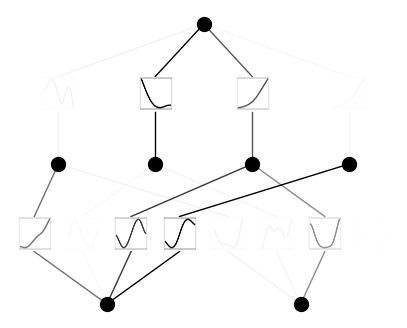

In [4]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [5]:
# sin appears at the top of the suggestion list, which is good!
model.suggest_symbolic(0,0,0)

function , r2
gaussian , 0.9922442436218262
sin , 0.9921897649765015
x^2 , 0.9917889833450317
cosh , 0.9915947914123535
x^3 , 0.9907029271125793


('gaussian',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9922442436218262)

In [6]:
# x^2 appears in the suggestion list (usually not top 1), but it is fine!
model.suggest_symbolic(0,1,0)

function , r2
x^4 , 0.9267642498016357
cosh , 0.9162518978118896
x^2 , 0.8414775133132935
gaussian , 0.839168906211853
sin , 0.8374858498573303


('x^4',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9267642498016357)

In [7]:
# exp not even appears in the list (but note how high correlation of all these functions), which is sad!
model.suggest_symbolic(1,0,0)

function , r2
sin , 0.8409020304679871
gaussian , 0.7846505045890808
tanh , 0.5559893250465393
sgn , 0.5475132465362549
arctan , 0.4854588210582733


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.8409020304679871)

In [8]:
# let's try suggesting more by changing topk. Exp should appear in the list
# But it's very unclear why should we prefer exp over others. All of them have quite high correlation with the learned spline.
model.suggest_symbolic(1,0,0,topk=15)

function , r2
sin , 0.8409020304679871
gaussian , 0.7846505045890808
tanh , 0.5559893250465393
sgn , 0.5475132465362549
arctan , 0.4854588210582733
sigmoid , 0.48509931564331055
abs , 0.3367708921432495
x^2 , 0.20711982250213623
cosh , 0.20664410293102264
x^3 , 0.2059362530708313
x^4 , 0.20575197041034698
exp , 0.20549941062927246
log , 0.20511242747306824
1/x , 0.20510898530483246
1/sqrt(x) , 0.2050294131040573


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.8409020304679871)

train loss: 5.01e-03 | test loss: 5.25e-03 | reg: 1.14e+01 : 100%|██| 20/20 [00:07<00:00,  2.85it/s]


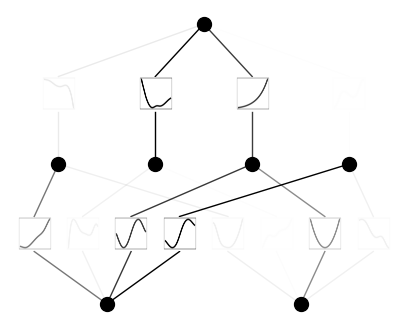

In [9]:
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [10]:
# sin appears at the top of the suggestion list, which is good!
model.suggest_symbolic(0,0,0)

function , r2
gaussian , 0.9934483766555786
sin , 0.9934346079826355
x^2 , 0.9932972192764282
cosh , 0.9932767152786255
x^3 , 0.9920275211334229


('gaussian',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9934483766555786)

In [11]:
# x^2 appears at the top of the suggestion list, which is good!
# But note how competitive cosh and gaussian are. They are also locally quadratic.
model.suggest_symbolic(0,1,0)

function , r2
cosh , 0.9937620759010315
x^2 , 0.9932071566581726
gaussian , 0.9926877617835999
sin , 0.9906584024429321
x^4 , 0.9277693033218384


('cosh',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9937620759010315)

In [12]:
# exp appears at the top of the suggestion list, which is good!
model.suggest_symbolic(1,0,0)

function , r2
tan , 0.9180852770805359
arctanh , 0.8920008540153503
x^3 , 0.8502706289291382
log , 0.8485129475593567
arcsin , 0.843649685382843


('tan',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9180852770805359)

In [13]:
# now let's replace every activation function with its top 1 symbolic suggestion. This is implmented in auto_symbolic()
model.auto_symbolic()

# if the user wants to constrain the symbolic space, they can pass in their symbolic libarary
# lib = ['sin', 'x^2', 'exp']
# model.auto_symbolic(lib=lib)

fixing (0,0,0) with gaussian, r2=0.9934483766555786
fixing (0,0,1) with sin, r2=0.7392392754554749
fixing (0,0,2) with sin, r2=0.9995235204696655
fixing (0,0,3) with sin, r2=0.9970577359199524
fixing (0,1,0) with cosh, r2=0.9937620759010315
fixing (0,1,1) with tan, r2=0.9700495004653931
fixing (0,1,2) with x^2, r2=0.9999983906745911
fixing (0,1,3) with arctan, r2=0.9460312128067017
fixing (1,0,0) with tan, r2=0.9180852770805359
fixing (1,1,0) with x^2, r2=0.6825717687606812
fixing (1,2,0) with exp, r2=0.9999974966049194
fixing (1,3,0) with x^3, r2=0.9720304608345032


train loss: 2.25e-02 | test loss: 2.05e-02 | reg: 1.69e+01 : 100%|██| 20/20 [00:01<00:00, 12.77it/s]


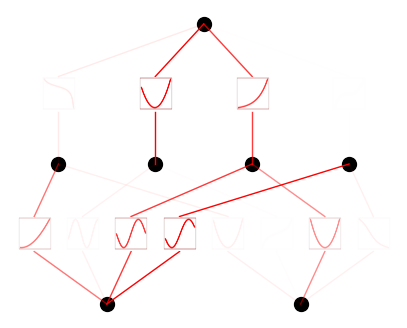

In [14]:
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [15]:
# obtaining symbolic formula
formula, variables = model.symbolic_formula()
formula[0]

-0.e-2*(sin(2.7*x_1 - 3.19) + 0.02*atan(1.65*x_2 + 0.54) - 0.02)**3 + 1.05*exp(0.98*x_2**2 + 0.98*sin(3.1*x_1)) - 0.04*tan(0.39*cosh(1.1*x_2 + 0.01) + 17.8 - 13.02*exp(-0.05*(-x_1 - 0.94)**2)) - 0.07

In [16]:
# if you want to rename your variables, you could use the "var" argument
formula, variables = model.symbolic_formula(var=['\\alpha','y'])
formula[0]

-0.e-2*(sin(2.7*\alpha - 3.19) + 0.02*atan(1.65*y + 0.54) - 0.02)**3 + 1.05*exp(0.98*y**2 + 0.98*sin(3.1*\alpha)) - 0.04*tan(0.39*cosh(1.1*y + 0.01) + 17.8 - 13.02*exp(-0.05*(-\alpha - 0.94)**2)) - 0.07

In [17]:
# one can even postprocess the formula (e.g., taking derivatives)
from sympy import *
diff(formula[0], variables[0])

0.5213*(-0.1*\alpha - 0.094)*(tan(0.39*cosh(1.1*y + 0.01) + 17.8 - 13.02*exp(-0.05*(-\alpha - 0.94)**2))**2 + 1)*exp(-0.05*(-\alpha - 0.94)**2) - 0.0791*(sin(2.7*\alpha - 3.19) + 0.02*atan(1.65*y + 0.54) - 0.02)**2*cos(2.7*\alpha - 3.19) + 3.19*exp(0.98*y**2 + 0.98*sin(3.1*\alpha))*cos(3.1*\alpha)

In [18]:
# let's replace (0,1,0) with cosh
model.fix_symbolic(0,1,0,'cosh')

r2 is 0.9999986290931702


tensor(1.0000)

train loss: 2.25e-02 | test loss: 2.05e-02 | reg: 1.69e+01 : 100%|██| 20/20 [00:01<00:00, 19.94it/s]


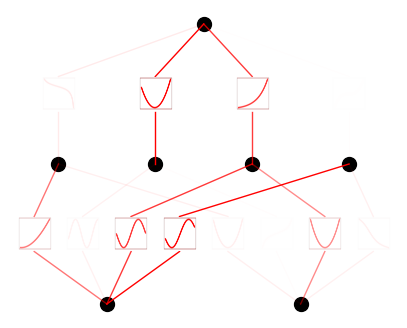

In [19]:
# this loss is stuck at around 1e-3 RMSE, which is good, but not machine precision.
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [20]:
def toy(bound=1., noise=0., fun=lambda x: torch.sin(torch.pi*x)):

    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = fun(x) + torch.normal(0,1,size=(num_pts,)) * noise
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=5, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    model.suggest_symbolic(0,0,0)
    model.plot()

train loss: 2.79e-03 | test loss: 2.79e-03 | reg: 3.12e-01 : 100%|██| 20/20 [00:01<00:00, 18.43it/s]


function , r2
sin , 0.9999845623970032
gaussian , 0.9184407591819763
tanh , 0.863538384437561
sigmoid , 0.86013263463974
arctan , 0.845004141330719


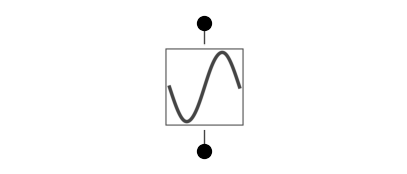

In [21]:
# when the function is whole range "bound=1."" (captures a whole period of sine) and has zero noise "noise=0."
# it is quite clear the function is clear
toy()

train loss: 9.22e-01 | test loss: 9.22e-01 | reg: 3.12e-01 : 100%|██| 20/20 [00:00<00:00, 28.59it/s]


function , r2
sin , 0.9999845623970032
gaussian , 0.9184413552284241
tanh , 0.8635390996932983
sigmoid , 0.8601328134536743
arctan , 0.845004677772522


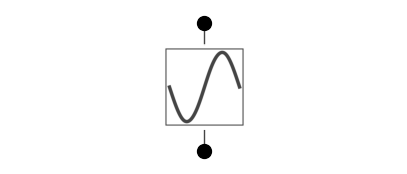

In [22]:
# even with large noise, sine can be revealed, yeah!
toy(noise=1.)

train loss: 9.22e-02 | test loss: 9.22e-02 | reg: 7.15e-01 : 100%|██| 20/20 [00:00<00:00, 36.54it/s]


function , r2
sin , 0.9999921321868896
arctan , 0.9999851584434509
tanh , 0.9999848008155823
cosh , 0.9999812841415405
x^4 , 0.999981164932251


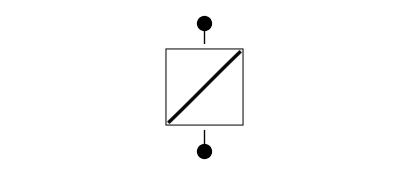

In [23]:
# but when bound is small and there is noise, it starts to screw up (at least becomes less clear why we should prefer sine)
toy(bound = 0.1, noise=0.1)

In [24]:
def mix(a, b, bound=1):
    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = a * torch.sin(x) + b * x**2 + (1-a-b) * torch.exp(x)
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=10, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    return model.suggest_symbolic(0,0,0)[0]


In [25]:
mix(a=0.2, b=0.0)

train loss: 2.42e-06 | test loss: 2.42e-06 | reg: 2.64e-01 : 100%|██| 20/20 [00:00<00:00, 22.27it/s]


function , r2
cosh , 0.9999977946281433
exp , 0.9999954700469971
sigmoid , 0.9999608993530273
tanh , 0.9999525547027588
1/x^4 , 0.9999521374702454


'cosh'

In [26]:
# let's do a phase diagram, which looks quite "fractal"
num = 11
a_arr = np.linspace(0,1,num=num)
b_arr = np.linspace(0,1,num=num)
sf_mat = np.empty((num,num), dtype='U8')

for i in range(num):
    for j in range(num):
        a = a_arr[i]; b = b_arr[j]
        sf_mat[i,j] = mix(a, b)

train loss: 2.78e-06 | test loss: 2.78e-06 | reg: 2.72e-01 : 100%|██| 20/20 [00:00<00:00, 20.26it/s]


function , r2
cosh , 1.0000004768371582
exp , 1.0000003576278687
tanh , 0.9999733567237854
sigmoid , 0.9999500513076782
1/x^4 , 0.9999372959136963


train loss: 2.53e-06 | test loss: 2.53e-06 | reg: 2.45e-01 : 100%|██| 20/20 [00:00<00:00, 21.43it/s]


function , r2
cosh , 0.9999992847442627
x^4 , 0.9999915957450867
gaussian , 0.9999678730964661
tanh , 0.9999523162841797
sigmoid , 0.9999488592147827


train loss: 2.30e-06 | test loss: 2.30e-06 | reg: 2.18e-01 : 100%|██| 20/20 [00:00<00:00, 21.40it/s]


function , r2
cosh , 0.9999950528144836
x^3 , 0.9999169707298279
gaussian , 0.9997471570968628
x^4 , 0.9996080994606018
tanh , 0.9995839595794678


train loss: 2.05e-06 | test loss: 2.05e-06 | reg: 1.94e-01 : 100%|██| 20/20 [00:00<00:00, 23.99it/s]


function , r2
cosh , 0.9999858736991882
x^3 , 0.9988142251968384
gaussian , 0.9985231161117554
x^2 , 0.9984781742095947
sin , 0.9981951713562012


train loss: 1.81e-06 | test loss: 1.81e-06 | reg: 1.71e-01 : 100%|██| 20/20 [00:01<00:00, 14.87it/s]


function , r2
cosh , 0.9999662637710571
x^2 , 0.9986101984977722
sin , 0.9982842803001404
x^3 , 0.9936586618423462
gaussian , 0.9936466813087463


train loss: 1.56e-06 | test loss: 1.56e-06 | reg: 1.51e-01 : 100%|██| 20/20 [00:00<00:00, 23.55it/s]


function , r2
cosh , 0.9999420046806335
x^2 , 0.9987950921058655
sin , 0.9984332323074341
gaussian , 0.9949685335159302
tanh , 0.9764367938041687


train loss: 1.31e-06 | test loss: 1.31e-06 | reg: 1.37e-01 : 100%|██| 20/20 [00:00<00:00, 22.39it/s]


function , r2
cosh , 0.9999043941497803
x^2 , 0.9990440607070923
sin , 0.9986634850502014
gaussian , 0.9958811402320862
tanh , 0.9380273818969727


train loss: 1.08e-06 | test loss: 1.08e-06 | reg: 1.29e-01 : 100%|██| 20/20 [00:00<00:00, 22.74it/s]


function , r2
cosh , 0.9998659491539001
x^2 , 0.999350905418396
sin , 0.9989812970161438
gaussian , 0.9916260242462158
x^4 , 0.9172568321228027


train loss: 8.39e-07 | test loss: 8.39e-07 | reg: 1.27e-01 : 100%|██| 20/20 [00:01<00:00, 19.44it/s]


function , r2
x^2 , 0.9996705055236816
sin , 0.9993890523910522
cosh , 0.9985609650611877
gaussian , 0.9707186818122864
abs , 0.9254010915756226


train loss: 6.03e-07 | test loss: 6.03e-07 | reg: 1.30e-01 : 100%|██| 20/20 [00:00<00:00, 24.64it/s]


function , r2
x^2 , 0.9999136924743652
sin , 0.9994937777519226
gaussian , 0.9994853734970093
cosh , 0.9879138469696045
abs , 0.9339753985404968


train loss: 3.80e-07 | test loss: 3.80e-07 | reg: 1.38e-01 : 100%|██| 20/20 [00:01<00:00, 19.33it/s]


function , r2
x^2 , 1.0000003576278687
cosh , 0.9999101758003235
gaussian , 0.9997107982635498
sin , 0.9989290833473206
abs , 0.9374391436576843


train loss: 2.59e-06 | test loss: 2.59e-06 | reg: 2.68e-01 : 100%|██| 20/20 [00:00<00:00, 20.94it/s]


function , r2
exp , 0.9999995231628418
arctan , 0.999980092048645
cosh , 0.9999772310256958
tanh , 0.9999635219573975
sigmoid , 0.9999544620513916


train loss: 2.35e-06 | test loss: 2.35e-06 | reg: 2.40e-01 : 100%|██| 20/20 [00:01<00:00, 16.37it/s]


function , r2
cosh , 0.9999939203262329
x^4 , 0.9999867081642151
gaussian , 0.9999642372131348
sigmoid , 0.9999452233314514
x^3 , 0.999944269657135


train loss: 2.10e-06 | test loss: 2.10e-06 | reg: 2.14e-01 : 100%|██| 20/20 [00:00<00:00, 22.66it/s]


function , r2
cosh , 0.9999949932098389
x^3 , 0.999884843826294
gaussian , 0.9997602701187134
tanh , 0.9996166229248047
sigmoid , 0.9996151924133301


train loss: 1.86e-06 | test loss: 1.86e-06 | reg: 1.89e-01 : 100%|██| 20/20 [00:00<00:00, 22.17it/s]


function , r2
cosh , 0.9999828338623047
x^2 , 0.9991238713264465
sin , 0.9988862872123718
x^3 , 0.9987775087356567
gaussian , 0.9986570477485657


train loss: 1.61e-06 | test loss: 1.61e-06 | reg: 1.66e-01 : 100%|██| 20/20 [00:00<00:00, 23.70it/s]


function , r2
cosh , 0.9999908804893494
x^2 , 0.999285876750946
sin , 0.9988725781440735
gaussian , 0.9985802173614502
x^3 , 0.9939917325973511


train loss: 1.38e-06 | test loss: 1.38e-06 | reg: 1.45e-01 : 100%|██| 20/20 [00:00<00:00, 23.79it/s]


function , r2
cosh , 0.9999797940254211
x^2 , 0.9994809627532959
sin , 0.9991910457611084
gaussian , 0.9964681267738342
tanh , 0.9772538542747498


train loss: 1.13e-06 | test loss: 1.13e-06 | reg: 1.29e-01 : 100%|██| 20/20 [00:00<00:00, 20.88it/s]


function , r2
cosh , 0.9999741315841675
x^2 , 0.9996978044509888
sin , 0.9994118809700012
gaussian , 0.9973543882369995
tanh , 0.9376919269561768


train loss: 8.89e-07 | test loss: 8.89e-07 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 22.07it/s]


function , r2
x^2 , 0.9998961687088013
cosh , 0.9998723864555359
sin , 0.9996592402458191
gaussian , 0.9939866662025452
abs , 0.9232653379440308


train loss: 6.54e-07 | test loss: 6.54e-07 | reg: 1.20e-01 : 100%|██| 20/20 [00:01<00:00, 19.11it/s]


function , r2
x^2 , 0.9999977350234985
sin , 0.9998342394828796
cosh , 0.9962063431739807
gaussian , 0.9754127264022827
abs , 0.9311625957489014


train loss: 4.21e-07 | test loss: 4.21e-07 | reg: 1.24e-01 : 100%|██| 20/20 [00:01<00:00, 12.81it/s]


function , r2
x^2 , 0.999923050403595
sin , 0.9998639225959778
cosh , 0.9997754096984863
gaussian , 0.99968022108078
abs , 0.9372402429580688


train loss: 2.26e-07 | test loss: 2.26e-07 | reg: 1.33e-01 : 100%|██| 20/20 [00:00<00:00, 22.30it/s]


function , r2
cosh , 0.9995568990707397
gaussian , 0.9993467926979065
sin , 0.9985871911048889
x^2 , 0.9984340667724609
abs , 0.9362896680831909


train loss: 2.41e-06 | test loss: 2.41e-06 | reg: 2.64e-01 : 100%|██| 20/20 [00:00<00:00, 24.18it/s]


function , r2
cosh , 0.9999977946281433
exp , 0.9999955296516418
sigmoid , 0.9999608993530273
tanh , 0.9999525547027588
1/x^4 , 0.9999521374702454


train loss: 2.17e-06 | test loss: 2.17e-06 | reg: 2.36e-01 : 100%|██| 20/20 [00:00<00:00, 22.22it/s]


function , r2
cosh , 0.9999990463256836
x^3 , 0.9999776482582092
x^4 , 0.9999701380729675
gaussian , 0.9999597668647766
sigmoid , 0.9999393224716187


train loss: 1.93e-06 | test loss: 1.93e-06 | reg: 2.09e-01 : 100%|██| 20/20 [00:00<00:00, 22.65it/s]


function , r2
cosh , 0.9999996423721313
x^3 , 0.9998224377632141
gaussian , 0.9997662305831909
tanh , 0.999638557434082
sigmoid , 0.9996371269226074


train loss: 1.67e-06 | test loss: 1.67e-06 | reg: 1.84e-01 : 100%|██| 20/20 [00:00<00:00, 21.79it/s]


function , r2
cosh , 0.9999991655349731
x^2 , 0.9996203780174255
sin , 0.9994373321533203
gaussian , 0.9987638592720032
x^3 , 0.9986606240272522


train loss: 1.44e-06 | test loss: 1.44e-06 | reg: 1.60e-01 : 100%|██| 20/20 [00:00<00:00, 20.03it/s]


function , r2
cosh , 0.9999956488609314
x^2 , 0.9997671246528625
sin , 0.999495804309845
gaussian , 0.9992839694023132
x^3 , 0.9941052198410034


train loss: 1.19e-06 | test loss: 1.19e-06 | reg: 1.39e-01 : 100%|██| 20/20 [00:01<00:00, 16.94it/s]


function , r2
x^2 , 0.9999061822891235
cosh , 0.9997879862785339
sin , 0.9997011423110962
gaussian , 0.9978270530700684
sigmoid , 0.9780415892601013


train loss: 9.46e-07 | test loss: 9.46e-07 | reg: 1.23e-01 : 100%|██| 20/20 [00:00<00:00, 21.04it/s]


function , r2
x^2 , 0.9999921917915344
sin , 0.9998542666435242
gaussian , 0.9985643625259399
cosh , 0.9978693127632141
tanh , 0.9372186660766602


train loss: 7.10e-07 | test loss: 7.10e-07 | reg: 1.15e-01 : 100%|██| 20/20 [00:00<00:00, 22.35it/s]


function , r2
x^2 , 0.9999417662620544
sin , 0.9999182224273682
cosh , 0.9993168711662292
gaussian , 0.9961113929748535
abs , 0.9302396774291992


train loss: 4.78e-07 | test loss: 4.78e-07 | reg: 1.14e-01 : 100%|██| 20/20 [00:00<00:00, 20.39it/s]


function , r2
sin , 0.9997866153717041
x^2 , 0.9996584057807922
cosh , 0.9942755103111267
gaussian , 0.9798856973648071
abs , 0.936910092830658


train loss: 2.67e-07 | test loss: 2.67e-07 | reg: 1.18e-01 : 100%|██| 20/20 [00:00<00:00, 20.60it/s]


function , r2
sin , 0.9992178678512573
x^2 , 0.9991378784179688
gaussian , 0.9990885257720947
cosh , 0.9988974928855896
abs , 0.939662754535675


train loss: 1.92e-07 | test loss: 1.92e-07 | reg: 1.27e-01 : 100%|██| 20/20 [00:00<00:00, 25.88it/s]


function , r2
x^2 , 0.9985411167144775
cosh , 0.9984979033470154
sin , 0.9981679916381836
gaussian , 0.9980800747871399
abs , 0.934815526008606


train loss: 2.23e-06 | test loss: 2.23e-06 | reg: 2.60e-01 : 100%|██| 20/20 [00:00<00:00, 20.76it/s]


function , r2
cosh , 0.9999932646751404
exp , 0.9999839663505554
tanh , 0.9999824166297913
x^4 , 0.9999750256538391
arctan , 0.9999717473983765


train loss: 2.03e-06 | test loss: 2.03e-06 | reg: 2.32e-01 : 100%|██| 20/20 [00:00<00:00, 21.55it/s]


function , r2
cosh , 0.9999966025352478
x^3 , 0.9999816417694092
gaussian , 0.9999538660049438
tanh , 0.9999339580535889
sigmoid , 0.9999309778213501


train loss: 1.74e-06 | test loss: 1.74e-06 | reg: 2.05e-01 : 100%|██| 20/20 [00:01<00:00, 16.76it/s]


function , r2
cosh , 0.9999964833259583
x^2 , 0.9998263716697693
gaussian , 0.9997668266296387
x^3 , 0.9997120499610901
sin , 0.9997116923332214


train loss: 1.50e-06 | test loss: 1.50e-06 | reg: 1.79e-01 : 100%|██| 20/20 [00:00<00:00, 24.16it/s]


function , r2
cosh , 0.9999545812606812
x^2 , 0.9999237656593323
sin , 0.999809980392456
gaussian , 0.9988470077514648
x^3 , 0.9984462261199951


train loss: 1.26e-06 | test loss: 1.26e-06 | reg: 1.55e-01 : 100%|██| 20/20 [00:00<00:00, 22.44it/s]


function , r2
x^2 , 0.9999879002571106
cosh , 0.9999626278877258
sin , 0.9998844265937805
gaussian , 0.9997446537017822
x^3 , 0.9939815998077393


train loss: 1.01e-06 | test loss: 1.01e-06 | reg: 1.33e-01 : 100%|██| 20/20 [00:00<00:00, 23.29it/s]


function , r2
x^2 , 0.9999664425849915
sin , 0.999883234500885
cosh , 0.999143123626709
gaussian , 0.9988927841186523
tanh , 0.978797972202301


train loss: 7.72e-07 | test loss: 7.72e-07 | reg: 1.17e-01 : 100%|██| 20/20 [00:00<00:00, 22.80it/s]


function , r2
sin , 0.9999326467514038
x^2 , 0.999760091304779
cosh , 0.9994867444038391
gaussian , 0.9994862079620361
tanh , 0.9365765452384949


train loss: 5.39e-07 | test loss: 5.39e-07 | reg: 1.08e-01 : 100%|██| 20/20 [00:00<00:00, 21.53it/s]


function , r2
sin , 0.9997549653053284
x^2 , 0.9992306232452393
cosh , 0.9979138970375061
gaussian , 0.9977999329566956
abs , 0.9377142786979675


train loss: 3.30e-07 | test loss: 3.30e-07 | reg: 1.07e-01 : 100%|██| 20/20 [00:00<00:00, 21.52it/s]


function , r2
sin , 0.9990792274475098
x^2 , 0.9983071684837341
cosh , 0.9912199378013611
gaussian , 0.9838364720344543
abs , 0.9422997832298279


train loss: 1.95e-07 | test loss: 1.95e-07 | reg: 1.12e-01 : 100%|██| 20/20 [00:01<00:00, 18.60it/s]


function , r2
sin , 0.9974242448806763
gaussian , 0.9973311424255371
x^2 , 0.9972000122070312
cosh , 0.99689120054245
abs , 0.9402045011520386


train loss: 3.07e-07 | test loss: 3.07e-07 | reg: 1.21e-01 : 100%|██| 20/20 [00:01<00:00, 15.22it/s]


function , r2
cosh , 0.9964801073074341
x^2 , 0.9963343739509583
sin , 0.9959864020347595
gaussian , 0.9956439137458801
abs , 0.9297642111778259


train loss: 2.06e-06 | test loss: 2.06e-06 | reg: 2.57e-01 : 100%|██| 20/20 [00:00<00:00, 21.43it/s]


function , r2
x^4 , 0.9999898672103882
x^3 , 0.9999840259552002
tanh , 0.9999814033508301
cosh , 0.999980628490448
sigmoid , 0.9999730587005615


train loss: 1.80e-06 | test loss: 1.80e-06 | reg: 2.28e-01 : 100%|██| 20/20 [00:00<00:00, 24.52it/s]


function , r2
cosh , 0.9999676942825317
gaussian , 0.9999465346336365
x^2 , 0.9999381899833679
x^3 , 0.9999350905418396
tanh , 0.9999257326126099


train loss: 1.56e-06 | test loss: 1.56e-06 | reg: 2.00e-01 : 100%|██| 20/20 [00:00<00:00, 20.91it/s]


function , r2
x^2 , 0.9999861717224121
cosh , 0.9999809861183167
sin , 0.9999337792396545
gaussian , 0.9997634291648865
tanh , 0.9996618628501892


train loss: 1.33e-06 | test loss: 1.33e-06 | reg: 1.74e-01 : 100%|██| 20/20 [00:00<00:00, 21.02it/s]


function , r2
x^2 , 0.9999808073043823
sin , 0.9999693036079407
cosh , 0.9996538758277893
gaussian , 0.9989100098609924
tanh , 0.9985538125038147


train loss: 1.07e-06 | test loss: 1.07e-06 | reg: 1.50e-01 : 100%|██| 20/20 [00:00<00:00, 21.85it/s]


function , r2
sin , 0.9999732375144958
gaussian , 0.9999253749847412
x^2 , 0.9998628497123718
cosh , 0.9996561408042908
tanh , 0.9942790865898132


train loss: 8.38e-07 | test loss: 8.38e-07 | reg: 1.28e-01 : 100%|██| 20/20 [00:00<00:00, 22.73it/s]


function , r2
sin , 0.9999428391456604
gaussian , 0.999909520149231
x^2 , 0.9995195269584656
cosh , 0.9978922605514526
tanh , 0.9795185327529907


train loss: 6.03e-07 | test loss: 6.03e-07 | reg: 1.10e-01 : 100%|██| 20/20 [00:01<00:00, 16.83it/s]


function , r2
sin , 0.9998137950897217
gaussian , 0.9997873306274414
x^2 , 0.9987618327140808
cosh , 0.9982634782791138
abs , 0.9422873854637146


train loss: 3.87e-07 | test loss: 3.87e-07 | reg: 1.02e-01 : 100%|██| 20/20 [00:01<00:00, 18.86it/s]


function , r2
sin , 0.9992998838424683
gaussian , 0.9987379908561707
x^2 , 0.9973756670951843
cosh , 0.9952552318572998
abs , 0.9455261826515198


train loss: 2.40e-07 | test loss: 2.40e-07 | reg: 1.00e-01 : 100%|██| 20/20 [00:00<00:00, 23.36it/s]


function , r2
sin , 0.9974730014801025
x^2 , 0.9954224228858948
gaussian , 0.9867523312568665
cosh , 0.9865828156471252
abs , 0.946847677230835


train loss: 2.99e-07 | test loss: 2.99e-07 | reg: 1.05e-01 : 100%|██| 20/20 [00:00<00:00, 22.76it/s]


function , r2
sin , 0.9938675165176392
gaussian , 0.9937913417816162
x^2 , 0.9936062097549438
cosh , 0.993238627910614
abs , 0.9381966590881348


train loss: 4.74e-07 | test loss: 4.74e-07 | reg: 1.16e-01 : 100%|██| 20/20 [00:00<00:00, 22.52it/s]


function , r2
x^2 , 0.9927310347557068
sin , 0.992283046245575
gaussian , 0.9916989207267761
cosh , 0.985639214515686
abs , 0.9212248921394348


train loss: 1.87e-06 | test loss: 1.87e-06 | reg: 2.53e-01 : 100%|██| 20/20 [00:00<00:00, 21.78it/s]


function , r2
cosh , 0.9999892115592957
x^2 , 0.9999853372573853
tanh , 0.9999764561653137
x^3 , 0.9999762177467346
sigmoid , 0.9999719262123108


train loss: 1.63e-06 | test loss: 1.63e-06 | reg: 2.24e-01 : 100%|██| 20/20 [00:00<00:00, 20.69it/s]


function , r2
x^2 , 0.9999876618385315
sin , 0.9999815225601196
cosh , 0.9999555349349976
gaussian , 0.9999386668205261
tanh , 0.9999181628227234


train loss: 1.39e-06 | test loss: 1.39e-06 | reg: 1.96e-01 : 100%|██| 20/20 [00:01<00:00, 15.39it/s]


function , r2
sin , 0.9999862909317017
gaussian , 0.999964714050293
x^2 , 0.9999218583106995
tanh , 0.9996706247329712
sigmoid , 0.9996693134307861


train loss: 1.14e-06 | test loss: 1.14e-06 | reg: 1.69e-01 : 100%|██| 20/20 [00:01<00:00, 13.71it/s]


function , r2
sin , 0.9999805092811584
x^2 , 0.9997262954711914
cosh , 0.9993475079536438
gaussian , 0.9989575147628784
tanh , 0.9986544847488403


train loss: 9.07e-07 | test loss: 9.07e-07 | reg: 1.44e-01 : 100%|██| 20/20 [00:00<00:00, 22.55it/s]


function , r2
sin , 0.9999589920043945
gaussian , 0.999949038028717
x^2 , 0.9992832541465759
cosh , 0.998874306678772
tanh , 0.994661808013916


train loss: 6.75e-07 | test loss: 6.75e-07 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 22.82it/s]


function , r2
sin , 0.9998828172683716
gaussian , 0.9998782873153687
x^2 , 0.9983745813369751
cosh , 0.9979462623596191
tanh , 0.9802092909812927


train loss: 4.62e-07 | test loss: 4.62e-07 | reg: 1.04e-01 : 100%|██| 20/20 [00:00<00:00, 22.01it/s]


function , r2
gaussian , 0.9995981454849243
sin , 0.9995940327644348
x^2 , 0.9966495633125305
cosh , 0.995880126953125
abs , 0.951285183429718


train loss: 3.01e-07 | test loss: 3.01e-07 | reg: 9.49e-02 : 100%|██| 20/20 [00:01<00:00, 19.94it/s]


function , r2
sin , 0.998451292514801
gaussian , 0.9959578514099121
x^2 , 0.9937822818756104
cosh , 0.9907206296920776
abs , 0.9534655809402466


train loss: 2.93e-07 | test loss: 2.93e-07 | reg: 9.38e-02 : 100%|██| 20/20 [00:01<00:00, 19.84it/s]


function , r2
sin , 0.9943904280662537
x^2 , 0.990205705165863
gaussian , 0.9877626299858093
cosh , 0.9761220216751099
abs , 0.949742317199707


train loss: 4.49e-07 | test loss: 4.49e-07 | reg: 9.92e-02 : 100%|██| 20/20 [00:00<00:00, 20.66it/s]


function , r2
x^2 , 0.9876754879951477
gaussian , 0.9876450896263123
sin , 0.987456738948822
cosh , 0.9873751997947693
abs , 0.9320315718650818


train loss: 6.45e-07 | test loss: 6.45e-07 | reg: 1.11e-01 : 100%|██| 20/20 [00:00<00:00, 21.12it/s]


function , r2
x^2 , 0.9873684644699097
sin , 0.9867107272148132
cosh , 0.9863604307174683
gaussian , 0.9859359860420227
x^4 , 0.9239130616188049


train loss: 1.70e-06 | test loss: 1.70e-06 | reg: 2.50e-01 : 100%|██| 20/20 [00:01<00:00, 13.13it/s]


function , r2
sin , 0.9999911189079285
tanh , 0.9999726414680481
sigmoid , 0.999970555305481
gaussian , 0.9999555349349976
x^2 , 0.9999527335166931


train loss: 1.45e-06 | test loss: 1.45e-06 | reg: 2.20e-01 : 100%|██| 20/20 [00:00<00:00, 21.71it/s]


function , r2
sin , 0.9999904036521912
gaussian , 0.9999315142631531
tanh , 0.9999148845672607
sigmoid , 0.9999135136604309
x^2 , 0.9998382329940796


train loss: 1.21e-06 | test loss: 1.21e-06 | reg: 1.92e-01 : 100%|██| 20/20 [00:00<00:00, 25.80it/s]


function , r2
sin , 0.9999867081642151
gaussian , 0.9997521042823792
tanh , 0.9996845722198486
sigmoid , 0.9996834397315979
x^2 , 0.9995862245559692


train loss: 9.86e-07 | test loss: 9.86e-07 | reg: 1.65e-01 : 100%|██| 20/20 [00:00<00:00, 25.21it/s]


function , r2
sin , 0.9999749064445496
x^2 , 0.9990827441215515
gaussian , 0.9989948868751526
cosh , 0.9988731145858765
tanh , 0.9987542629241943


train loss: 7.51e-07 | test loss: 7.51e-07 | reg: 1.39e-01 : 100%|██| 20/20 [00:00<00:00, 22.26it/s]


function , r2
sin , 0.9999372363090515
x^2 , 0.99811190366745
cosh , 0.997477114200592
gaussian , 0.9957320094108582
tanh , 0.9950295090675354


train loss: 5.40e-07 | test loss: 5.40e-07 | reg: 1.16e-01 : 100%|██| 20/20 [00:00<00:00, 21.94it/s]


function , r2
gaussian , 0.9998222589492798
sin , 0.9998034238815308
x^2 , 0.9962720274925232
cosh , 0.9957029819488525
tanh , 0.9808864593505859


train loss: 3.74e-07 | test loss: 3.74e-07 | reg: 9.77e-02 : 100%|██| 20/20 [00:00<00:00, 23.03it/s]


function , r2
gaussian , 0.9993160367012024
sin , 0.9992740750312805
x^2 , 0.9929139614105225
cosh , 0.9918352365493774
abs , 0.9605172872543335


train loss: 3.21e-07 | test loss: 3.21e-07 | reg: 8.81e-02 : 100%|██| 20/20 [00:01<00:00, 17.29it/s]


function , r2
sin , 0.9970617890357971
gaussian , 0.9966418743133545
x^2 , 0.9875211119651794
cosh , 0.9833481311798096
abs , 0.9611251354217529


train loss: 4.36e-07 | test loss: 4.36e-07 | reg: 8.72e-02 : 100%|██| 20/20 [00:01<00:00, 16.31it/s]


function , r2
sin , 0.9888256788253784
x^2 , 0.9814247488975525
gaussian , 0.9756945967674255
cosh , 0.9653652906417847
abs , 0.9498924016952515


train loss: 6.26e-07 | test loss: 6.26e-07 | reg: 9.30e-02 : 100%|██| 20/20 [00:00<00:00, 22.90it/s]


function , r2
x^2 , 0.9784855246543884
cosh , 0.9783727526664734
gaussian , 0.9779769778251648
sin , 0.9773945212364197
abs , 0.9202472567558289


train loss: 8.51e-07 | test loss: 8.51e-07 | reg: 1.06e-01 : 100%|██| 20/20 [00:00<00:00, 21.13it/s]


function , r2
cosh , 0.9847798347473145
x^2 , 0.9798817038536072
sin , 0.9789559841156006
gaussian , 0.9779178500175476
x^4 , 0.92859947681427


train loss: 1.53e-06 | test loss: 1.53e-06 | reg: 2.46e-01 : 100%|██| 20/20 [00:00<00:00, 21.56it/s]


function , r2
sin , 0.9999935030937195
gaussian , 0.9999931454658508
tanh , 0.9999732971191406
sigmoid , 0.9999719858169556
arctan , 0.9999525547027588


train loss: 1.29e-06 | test loss: 1.29e-06 | reg: 2.17e-01 : 100%|██| 20/20 [00:00<00:00, 22.53it/s]


function , r2
sin , 0.9999920129776001
gaussian , 0.9999265670776367
tanh , 0.9999195337295532
sigmoid , 0.9999184012413025
arctan , 0.9998357892036438


train loss: 1.06e-06 | test loss: 1.06e-06 | reg: 1.88e-01 : 100%|██| 20/20 [00:00<00:00, 25.57it/s]


function , r2
gaussian , 0.9999904036521912
sin , 0.9999871253967285
tanh , 0.9997100830078125
sigmoid , 0.9997090697288513
arctan , 0.9993953704833984


train loss: 8.24e-07 | test loss: 8.24e-07 | reg: 1.60e-01 : 100%|██| 20/20 [00:00<00:00, 21.74it/s]


function , r2
sin , 0.9999715685844421
gaussian , 0.9990280866622925
tanh , 0.9988658428192139
sigmoid , 0.9988647699356079
x^2 , 0.997957170009613


train loss: 6.13e-07 | test loss: 6.13e-07 | reg: 1.34e-01 : 100%|██| 20/20 [00:01<00:00, 16.30it/s]


function , r2
gaussian , 0.9999415874481201
sin , 0.9999187588691711
x^2 , 0.9961771368980408
tanh , 0.9954058527946472
sigmoid , 0.9954048991203308


train loss: 4.45e-07 | test loss: 4.45e-07 | reg: 1.11e-01 : 100%|██| 20/20 [00:00<00:00, 21.79it/s]


function , r2
gaussian , 0.9997739791870117
sin , 0.9997171759605408
x^2 , 0.9928627610206604
cosh , 0.9921525716781616
tanh , 0.9815841913223267


train loss: 3.70e-07 | test loss: 3.70e-07 | reg: 9.14e-02 : 100%|██| 20/20 [00:00<00:00, 22.00it/s]


function , r2
gaussian , 0.9989711046218872
sin , 0.9988547563552856
x^2 , 0.9868030548095703
cosh , 0.9853452444076538
abs , 0.9698774218559265


train loss: 4.41e-07 | test loss: 4.41e-07 | reg: 8.13e-02 : 100%|██| 20/20 [00:00<00:00, 22.27it/s]


function , r2
gaussian , 0.9949374198913574
sin , 0.9949111938476562
x^2 , 0.9771133661270142
cosh , 0.9716176986694336
abs , 0.9677231311798096


train loss: 6.04e-07 | test loss: 6.04e-07 | reg: 8.01e-02 : 100%|██| 20/20 [00:00<00:00, 20.24it/s]


function , r2
sin , 0.9790427684783936
gaussian , 0.9715245366096497
x^2 , 0.9671696424484253
cosh , 0.9450167417526245
abs , 0.9448630213737488


train loss: 8.20e-07 | test loss: 8.20e-07 | reg: 8.70e-02 : 100%|██| 20/20 [00:00<00:00, 22.02it/s]


function , r2
cosh , 0.9654617309570312
x^2 , 0.9648935794830322
sin , 0.9638569355010986
gaussian , 0.9636803269386292
x^4 , 0.900275468826294


train loss: 1.03e-06 | test loss: 1.03e-06 | reg: 1.03e-01 : 100%|██| 20/20 [00:00<00:00, 20.27it/s]


function , r2
cosh , 0.9807411432266235
x^2 , 0.9699724912643433
sin , 0.9677164554595947
gaussian , 0.9394859671592712
x^4 , 0.9351861476898193


train loss: 1.36e-06 | test loss: 1.36e-06 | reg: 2.43e-01 : 100%|██| 20/20 [00:01<00:00, 11.31it/s]


function , r2
gaussian , 0.9999983310699463
sin , 0.9999961256980896
tanh , 0.9999803900718689
sigmoid , 0.9999794363975525
arctan , 0.999964714050293


train loss: 1.13e-06 | test loss: 1.13e-06 | reg: 2.13e-01 : 100%|██| 20/20 [00:01<00:00, 12.77it/s]


function , r2
sin , 0.9999948143959045
tanh , 0.9999347925186157
sigmoid , 0.9999338984489441
gaussian , 0.9999252557754517
arctan , 0.9998689293861389


train loss: 9.03e-07 | test loss: 9.03e-07 | reg: 1.84e-01 : 100%|██| 20/20 [00:01<00:00, 18.26it/s]


function , r2
sin , 0.9999901056289673
tanh , 0.9997530579566956
sigmoid , 0.9997521042823792
gaussian , 0.9997518062591553
arctan , 0.9994998574256897


train loss: 6.93e-07 | test loss: 6.93e-07 | reg: 1.56e-01 : 100%|██| 20/20 [00:00<00:00, 20.39it/s]


function , r2
gaussian , 0.9999900460243225
sin , 0.9999505281448364
tanh , 0.9990032911300659
sigmoid , 0.9990023970603943
arctan , 0.9981098771095276


train loss: 5.19e-07 | test loss: 5.19e-07 | reg: 1.30e-01 : 100%|██| 20/20 [00:00<00:00, 24.30it/s]


function , r2
gaussian , 0.9999538660049438
sin , 0.9999096393585205
tanh , 0.9958220720291138
sigmoid , 0.9958210587501526
x^2 , 0.9932664036750793


train loss: 4.23e-07 | test loss: 4.23e-07 | reg: 1.06e-01 : 100%|██| 20/20 [00:00<00:00, 23.48it/s]


function , r2
gaussian , 0.999754786491394
sin , 0.9996393918991089
x^2 , 0.9876787066459656
cosh , 0.9868295788764954
tanh , 0.9823619723320007


train loss: 4.61e-07 | test loss: 4.61e-07 | reg: 8.53e-02 : 100%|██| 20/20 [00:00<00:00, 20.16it/s]


function , r2
gaussian , 0.998526930809021
sin , 0.9983500838279724
abs , 0.9785906672477722
x^2 , 0.9771997928619385
cosh , 0.9752848148345947


train loss: 5.98e-07 | test loss: 5.98e-07 | reg: 7.45e-02 : 100%|██| 20/20 [00:01<00:00, 14.26it/s]


function , r2
gaussian , 0.9917387962341309
sin , 0.9917001724243164
abs , 0.9717774391174316
x^2 , 0.9601570963859558
cosh , 0.9530802965164185


train loss: 7.98e-07 | test loss: 7.98e-07 | reg: 7.32e-02 : 100%|██| 20/20 [00:01<00:00, 19.13it/s]


KeyboardInterrupt: 

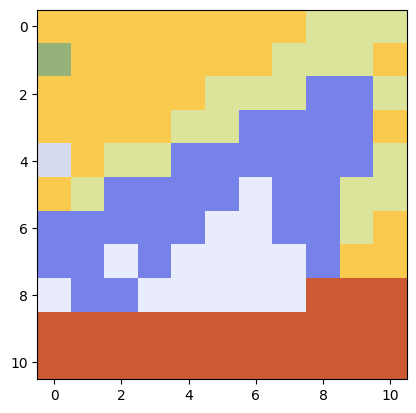

In [27]:
classes = list(set(sf_mat.reshape(-1,)))
n_class = len(classes)

colors = np.random.rand(n_class,4)
dic = {}
for i in range(n_class):
    dic[classes[i]] = colors[i]


img = np.zeros((num,num,4))
for i in range(num):
    for j in range(num):
        img[i][j] = dic[sf_mat[i][j]]
plt.imshow(img)

In [28]:
# we have used the default symbolic library whch contains the following functions
SYMBOLIC_LIB.keys()

dict_keys(['x', 'x^2', 'x^3', 'x^4', '1/x', '1/x^2', '1/x^3', '1/x^4', 'sqrt', '1/sqrt(x)', 'exp', 'log', 'abs', 'sin', 'tan', 'tanh', 'sigmoid', 'sgn', 'arcsin', 'arctan', 'arctanh', '0', 'gaussian', 'cosh'])

In [29]:
# we may constrain to a smaller library (pass as parameter "lib=lib" in suggest_symbolic)
lib = ['exp', 'x^2', 'sin']
def mix(a, b, bound=1):
    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = a * torch.sin(x) + b * x**2 + (1-a-b) * torch.exp(x)
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=10, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    return model.suggest_symbolic(0,0,0,lib=lib)[0]

In [30]:
# we can redo the analysis for a more contrained (bound) region. The phase diagram becomes even more "fractal"
num = 11
a_arr = np.linspace(0,1,num=num)
b_arr = np.linspace(0,1,num=num)
sf_mat = np.empty((num,num), dtype='U8')

for i in range(num):
    for j in range(num):
        a = a_arr[i]; b = b_arr[j]
        sf_mat[i,j] = mix(a, b, bound=0.3)

train loss: 4.28e-08 | test loss: 4.28e-08 | reg: 2.58e-01 : 100%|██| 20/20 [00:01<00:00, 15.74it/s]


function , r2
exp , 1.0000003576278687
x^2 , 0.9999844431877136
sin , 0.9999198913574219


train loss: 6.22e-08 | test loss: 6.22e-08 | reg: 2.30e-01 : 100%|██| 20/20 [00:01<00:00, 19.59it/s]


function , r2
exp , 0.9999967217445374
x^2 , 0.999984860420227
sin , 0.999906063079834


train loss: 8.15e-08 | test loss: 8.15e-08 | reg: 2.03e-01 : 100%|██| 20/20 [00:01<00:00, 19.41it/s]


function , r2
x^2 , 0.999984860420227
exp , 0.9999766945838928
sin , 0.9998868703842163


train loss: 4.40e-08 | test loss: 4.40e-08 | reg: 1.77e-01 : 100%|██| 20/20 [00:00<00:00, 22.29it/s]


function , r2
x^2 , 0.999984622001648
exp , 0.9999104142189026
sin , 0.9998597502708435


train loss: 2.34e-07 | test loss: 2.34e-07 | reg: 1.50e-01 : 100%|██| 20/20 [00:00<00:00, 28.39it/s]


function , r2
x^2 , 0.999984860420227
sin , 0.9998196959495544
exp , 0.9997115135192871


train loss: 2.73e-08 | test loss: 2.73e-08 | reg: 1.24e-01 : 100%|██| 20/20 [00:00<00:00, 23.69it/s]


function , r2
x^2 , 0.9999853372573853
sin , 0.9997580051422119
exp , 0.9991053938865662


train loss: 2.46e-08 | test loss: 2.46e-08 | reg: 9.83e-02 : 100%|██| 20/20 [00:00<00:00, 24.60it/s]


function , r2
x^2 , 0.999985933303833
sin , 0.9996548295021057
exp , 0.9971044659614563


train loss: 4.42e-08 | test loss: 4.42e-08 | reg: 7.39e-02 : 100%|██| 20/20 [00:00<00:00, 21.44it/s]


function , r2
x^2 , 0.9999868273735046
sin , 0.9994733929634094
exp , 0.9895645380020142


train loss: 1.62e-08 | test loss: 1.62e-08 | reg: 5.19e-02 : 100%|██| 20/20 [00:00<00:00, 23.45it/s]


function , r2
x^2 , 0.9999895095825195
sin , 0.9991207718849182
exp , 0.9559775590896606


train loss: 1.63e-08 | test loss: 1.63e-08 | reg: 3.99e-02 : 100%|██| 20/20 [00:00<00:00, 25.42it/s]


function , r2
x^2 , 0.999992847442627
sin , 0.9987167119979858
exp , 0.7906888723373413


train loss: 1.14e-08 | test loss: 1.14e-08 | reg: 3.92e-02 : 100%|██| 20/20 [00:00<00:00, 21.20it/s]


function , r2
x^2 , 0.9999985098838806
sin , 0.9975488185882568
exp , 0.2695852518081665


train loss: 6.97e-08 | test loss: 6.97e-08 | reg: 2.55e-01 : 100%|██| 20/20 [00:01<00:00, 15.95it/s]


function , r2
exp , 1.0000005960464478
x^2 , 0.9999902844429016
sin , 0.9999335408210754


train loss: 5.20e-08 | test loss: 5.20e-08 | reg: 2.28e-01 : 100%|██| 20/20 [00:01<00:00, 14.37it/s]


function , r2
exp , 0.9999971389770508
x^2 , 0.9999908208847046
sin , 0.999921977519989


train loss: 5.50e-08 | test loss: 5.50e-08 | reg: 2.02e-01 : 100%|██| 20/20 [00:01<00:00, 17.82it/s]


function , r2
x^2 , 0.9999914765357971
exp , 0.9999803304672241
sin , 0.9999063611030579


train loss: 4.01e-08 | test loss: 4.01e-08 | reg: 1.75e-01 : 100%|██| 20/20 [00:00<00:00, 20.73it/s]


function , r2
x^2 , 0.999992311000824
exp , 0.9999251365661621
sin , 0.9998840689659119


train loss: 3.09e-07 | test loss: 3.09e-07 | reg: 1.49e-01 : 100%|██| 20/20 [00:00<00:00, 28.95it/s]


function , r2
x^2 , 0.9999935030937195
sin , 0.9998512864112854
exp , 0.9997588396072388


train loss: 4.95e-08 | test loss: 4.95e-08 | reg: 1.23e-01 : 100%|██| 20/20 [00:00<00:00, 21.28it/s]


function , r2
x^2 , 0.9999949932098389
sin , 0.9997997283935547
exp , 0.9992485046386719


train loss: 4.92e-08 | test loss: 4.92e-08 | reg: 9.78e-02 : 100%|██| 20/20 [00:00<00:00, 20.87it/s]


function , r2
x^2 , 0.9999967217445374
sin , 0.9997135400772095
exp , 0.9975458383560181


train loss: 1.76e-08 | test loss: 1.76e-08 | reg: 7.41e-02 : 100%|██| 20/20 [00:00<00:00, 22.62it/s]


function , r2
x^2 , 0.9999988675117493
sin , 0.9995579719543457
exp , 0.9909899234771729


train loss: 1.28e-08 | test loss: 1.28e-08 | reg: 5.31e-02 : 100%|██| 20/20 [00:00<00:00, 21.15it/s]


function , r2
x^2 , 0.9999993443489075
sin , 0.9992666244506836
exp , 0.9605287909507751


train loss: 9.99e-09 | test loss: 9.99e-09 | reg: 4.02e-02 : 100%|██| 20/20 [00:00<00:00, 20.69it/s]


function , r2
x^2 , 0.999991774559021
sin , 0.9988726377487183
exp , 0.8001174926757812


train loss: 1.06e-08 | test loss: 1.06e-08 | reg: 4.05e-02 : 100%|██| 20/20 [00:00<00:00, 21.64it/s]


function , r2
x^2 , 0.9999648928642273
sin , 0.9978433847427368
exp , 0.28145459294319153


train loss: 4.82e-08 | test loss: 4.82e-08 | reg: 2.53e-01 : 100%|██| 20/20 [00:00<00:00, 23.73it/s]


function , r2
exp , 1.0000004768371582
x^2 , 0.9999946355819702
sin , 0.9999455809593201


train loss: 4.15e-08 | test loss: 4.15e-08 | reg: 2.26e-01 : 100%|██| 20/20 [00:01<00:00, 16.72it/s]


KeyboardInterrupt: 

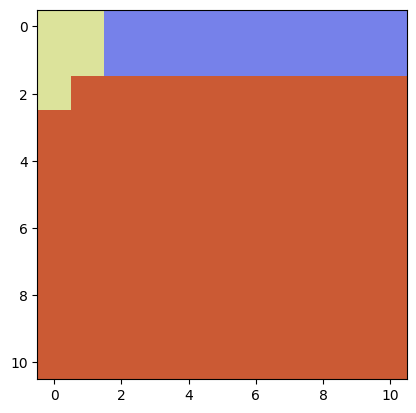

In [31]:
classes = list(set(sf_mat.reshape(-1,)))
n_class = len(classes)

colors = np.random.rand(n_class,4)
dic = {}
for i in range(n_class):
    dic[classes[i]] = colors[i]


img = np.zeros((num,num,4))
for i in range(num):
    for j in range(num):
        img[i][j] = dic[sf_mat[i][j]]
plt.imshow(img)